Using Xlense from FieldLensing
==========

Load modules
----------

In [1]:
using FFTW
FFTW.set_num_threads(5)

using BenchmarkTools
using LBblocks
using Spectra
using XFields
using FieldLensing
using FFTransforms
using PyPlot

Set fourier grid parameters
----------

In [2]:
trn = @sblock let θpix′ = 2.5, nside = 512
    θpix = deg2rad(θpix′/60)
    period = nside * θpix
    𝕨 = r𝕎32(nside, period) ⊗ 𝕎(nside, period)
    ordinary_scale(𝕨)*𝕨
end

𝕎{Float32,2,Float64,Float64}((512, 512), (true, true), 8.416904185929444e-8, (0.37233690709212364, 0.37233690709212364))

Compute the spectral matrices which mimic CMB tempurature and lesing potential
------------------------------

In [3]:
Ct, Cϕ = @sblock let trn
    l   = wavenum(trn)
    #cTl = Spectra.cTl_approx.(l)
    cTl = Spectra.cTl_besselj_approx.(l)
    #cTl = Spectra.cTl_matern_cov_approx.(l)
    cϕl = Spectra.cϕl_approx.(l)

    Ct  = DiagOp(Xfourier(trn, cTl))
    Cϕ  = DiagOp(Xfourier(trn, cϕl))

    Ct, Cϕ
end;

Visualize how close the fluctuations look.
---------------

In [4]:
T, ϕ = @sblock let trn, Ct, Cϕ
    zTx = randn(eltype_in(trn),size_in(trn)) ./ √Ωx(trn)
    zϕx = randn(eltype_in(trn),size_in(trn)) ./ √Ωx(trn)

    T = √Ct * Xmap(trn, zTx)
    ϕ = √Cϕ * Xmap(trn, zϕx)

    # extra scale factor for larger lense
    sc = 1.5

    T, sc * ϕ
end;

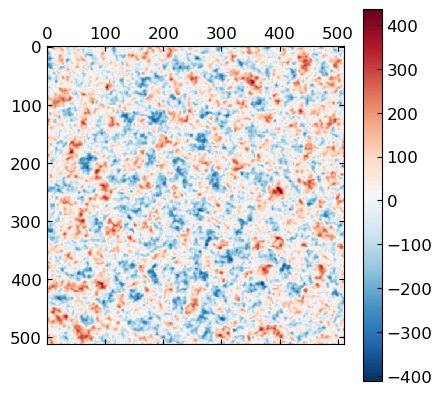

In [5]:
T[:] |> matshow; colorbar();

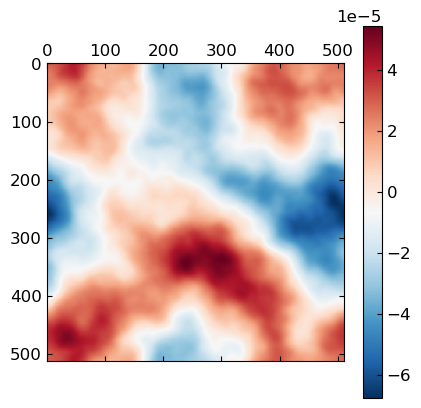

In [6]:
ϕ[:] |> matshow; colorbar();

Construct lense and adjoint lense
---------------

Start by defining the gradient operator and use it to compute the lensing displacements

In [7]:
∇ = @sblock let trn
    k = fullfreq(trn)
    ik1 = Xfourier(trn, im .* k[1]) |> DiagOp
    ik2 = Xfourier(trn, im .* k[2]) |> DiagOp
    (ik1, ik2)
end;

In [8]:
vϕ = (∇[1] * ϕ, ∇[2] * ϕ)

(Xmap{𝕎{Float32,2,Float64,Float64},Float32,ComplexF32,2}(𝕎{Float32,2,Float64,Float64}((512, 512), (true, true), 8.416904185929444e-8, (0.37233690709212364, 0.37233690709212364)), Float32[-0.00015530613 -0.00016150283 … -0.00013284122 -0.00014634221; -0.0002083755 -0.00022262629 … -0.00016577622 -0.00018962355; … ; -3.9264225f-5 -5.3662654f-5 … -2.315438f-5 -2.980065f-5; -9.591978f-5 -0.00010342833 … -8.5099244f-5 -9.078117f-5]), Xmap{𝕎{Float32,2,Float64,Float64},Float32,ComplexF32,2}(𝕎{Float32,2,Float64,Float64}((512, 512), (true, true), 8.416904185929444e-8, (0.37233690709212364, 0.37233690709212364)), Float32[0.0002819496 0.0002495202 … 0.00035029877 0.00031443444; 0.00027067735 0.00024114184 … 0.00032916534 0.00029832576; … ; 0.00029525327 0.0002721536 … 0.000365995 0.00032813876; 0.0002871792 0.00025774413 … 0.00036043584 0.00032220766]))

Now construct the lensing and adjoint lensing operator

In [9]:
L, Lʰ = @sblock let trn, vϕ, nsteps=16
    t₀ = 0
    t₁ = 1
    nsteps = 16
    L  = FieldLensing.Xlense(trn, vϕ, t₀, t₁, nsteps)
    L, L'
end;

Lense the field
---------------

Forward lensing field

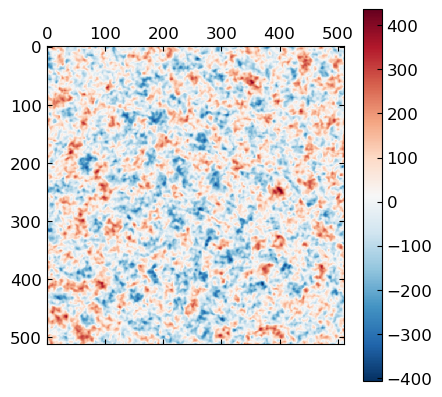

In [10]:
lenT1 = L * T
lenT1[:] |> matshow; colorbar();

Difference between lensed and un-lensed

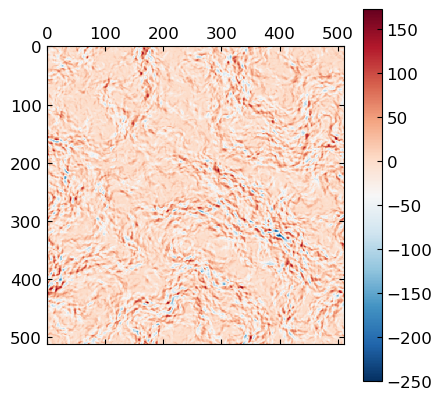

In [11]:
(T - lenT1)[:] |> matshow; colorbar();

Invert the lense and compare

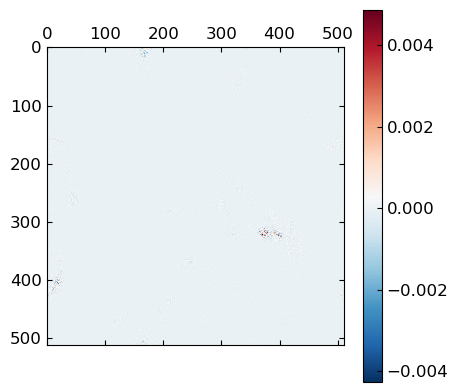

In [12]:
T1 = L \ lenT1
(T - T1)[:] |> matshow; colorbar();

adjoint Lense the field
---------------

Forward adjoint lensing field

In [13]:
lenʰT1 = Lʰ * T

Xmap{𝕎{Float32,2,Float64,Float64},Float32,ComplexF32,2}(𝕎{Float32,2,Float64,Float64}((512, 512), (true, true), 8.416904185929444e-8, (0.37233690709212364, 0.37233690709212364)), Float32[10.441471 17.018501 … -17.20002 -0.014493138; 1.699337 -4.266313 … -11.104167 1.426285; … ; 55.263153 66.58363 … 2.3692586 33.00263; 30.242626 43.677155 … -12.552248 11.567886])

Difference between adjoint lensing and un-lensed

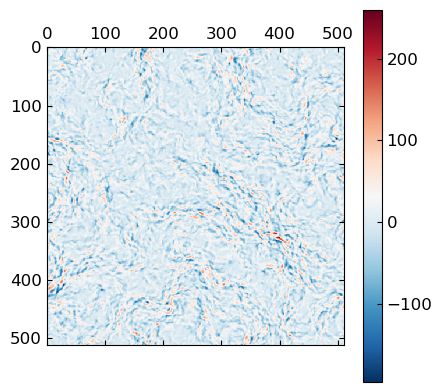

In [14]:
(T - lenʰT1)[:] |> matshow; colorbar();

Invert the lense and compare

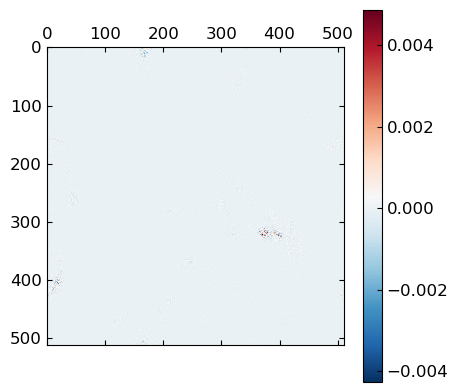

In [15]:
ʰT1 = Lʰ \ lenʰT1
(T - T1)[:] |> matshow; colorbar();

The lense objects are AbstractLinearOps
---------------
... so they work well with DiagOps

In [16]:
A = DiagOp(Xmap(ϕ))
B = A * L / Ct * L' * A';

In [17]:
f1 = B * T
f2 = A * (L * (Ct \ (L' * (A' * T))))
√sum(abs2, (f1 - f2)[:])

4.3669957f-6

Finally some benchmarks
----------------

In [18]:
@benchmark $L * $T

BenchmarkTools.Trial: 
  memory estimate:  38.94 MiB
  allocs estimate:  21769
  --------------
  minimum time:     159.390 ms (0.63% GC)
  median time:      169.499 ms (0.59% GC)
  mean time:        170.086 ms (0.56% GC)
  maximum time:     181.255 ms (0.56% GC)
  --------------
  samples:          30
  evals/sample:     1

In [19]:
@benchmark $Lʰ * $T

BenchmarkTools.Trial: 
  memory estimate:  39.48 MiB
  allocs estimate:  28041
  --------------
  minimum time:     169.520 ms (0.80% GC)
  median time:      178.737 ms (0.63% GC)
  mean time:        181.896 ms (0.63% GC)
  maximum time:     203.526 ms (0.72% GC)
  --------------
  samples:          28
  evals/sample:     1